In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Let's go ahead and start with some imports
import pandas as pd
from pandas import Series,DataFrame
import numpy as np

# For Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# For reading stock data from yahoo
# from pandas.io.data import DataReader

# For time stamps
from datetime import datetime

# For division
from __future__ import division

In [ ]:
# Plot defaults 
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 15

In [ ]:
# The tech stocks we'll use for this analysis
TSLA = pd.read_csv("/content/drive/MyDrive/Tugas Time Series, Volatility, Monte Carlo/monte carlo/TSLA.csv")
TSLA

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.000000,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.420000,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.920000,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.100000,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.000000,15.830000,16.110001,16.110001,6866900
...,...,...,...,...,...,...,...
2411,2020-01-28,568.489990,576.809998,558.080017,566.900024,566.900024,11788500
2412,2020-01-29,575.690002,589.799988,567.429993,580.989990,580.989990,17801500
2413,2020-01-30,632.419983,650.880005,618.000000,640.809998,640.809998,29005700
2414,2020-01-31,640.000000,653.000000,632.520020,650.570007,650.570007,15719300


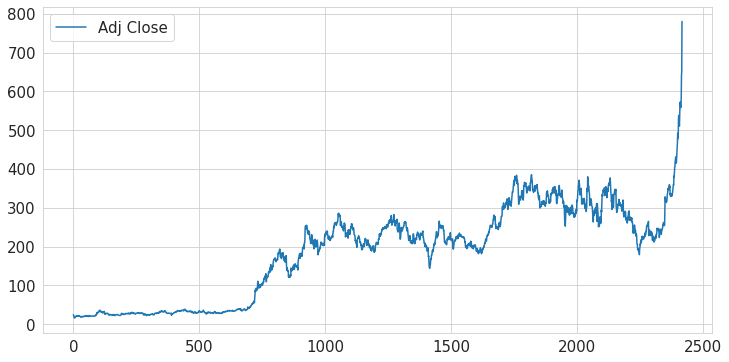

In [ ]:
# Let's see a historical view of the closing price
TSLA['Adj Close'].plot(legend=True,figsize=(12,6))

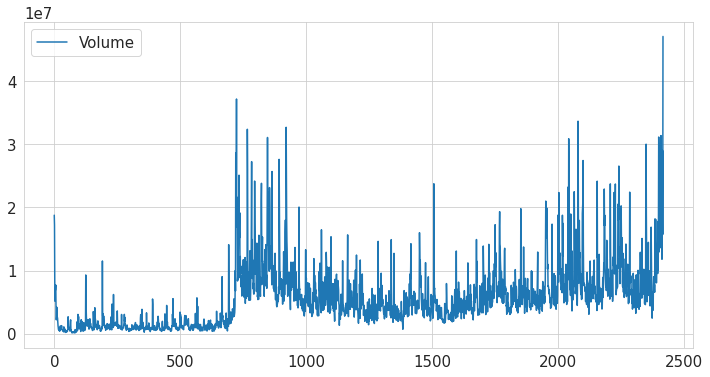

In [ ]:
# Now let's plot the total volume of stock being traded each day over the past 2 years
TSLA['Volume'].plot(legend=True,figsize=(12,6))

In [ ]:
# Luckily pandas has a built-in rolling mean calculator

# Let's go ahead and plot out several moving averages
ma_day = [10,20,50]

for ma in ma_day:
    column_name = "MA for %s days" %(str(ma))
    TSLA[column_name]= TSLA['Adj Close'].rolling(window=ma).mean()

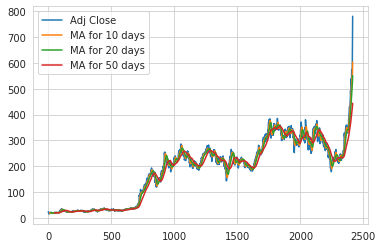

In [ ]:
TSLA[['Adj Close','MA for 10 days','MA for 20 days','MA for 50 days']].plot(subplots=False)

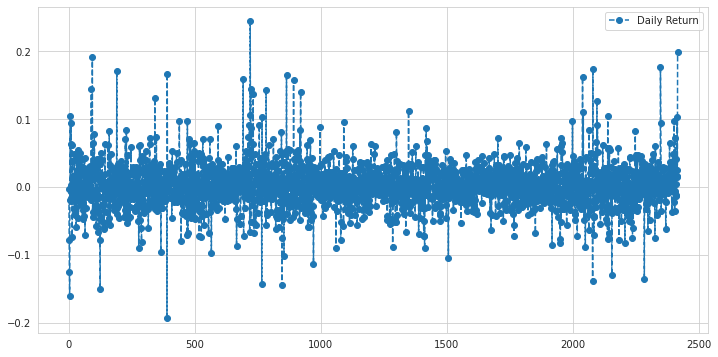

In [ ]:
# We'll use pct_change to find the percent change for each day
TSLA['Daily Return'] = TSLA['Adj Close'].pct_change()
# Then we'll plot the daily return percentage
TSLA['Daily Return'].plot(figsize=(12,6),legend=True,linestyle='--',marker='o')

In [ ]:
TSLA['Daily Return'].head()

0         NaN
1   -0.002511
2   -0.078473
3   -0.125683
4   -0.160937
Name: Daily Return, dtype: float64

In [ ]:
TSLA.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,MA for 10 days,MA for 20 days,MA for 50 days,Daily Return
2411,2020-01-28,568.489990,576.809998,558.080017,566.900024,566.900024,11788500,545.911005,503.125003,418.773402,0.015913
2412,2020-01-29,575.690002,589.799988,567.429993,580.989990,580.989990,17801500,550.218005,511.439502,423.406202,0.024854
2413,2020-01-30,632.419983,650.880005,618.000000,640.809998,640.809998,29005700,562.449005,522.563503,429.179001,0.102962
2414,2020-01-31,640.000000,653.000000,632.520020,650.570007,650.570007,15719300,576.157007,533.579002,435.190602,0.015231
2415,2020-02-03,673.690002,786.140015,673.520020,780.000000,780.000000,47065000,603.107007,550.428502,443.600202,0.198949


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


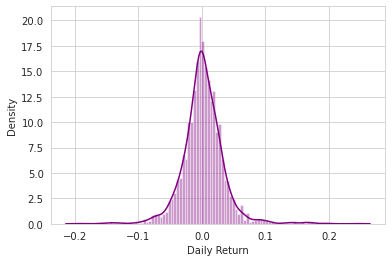

In [ ]:
# Note the use of dropna() here, otherwise the NaN values can't be read by seaborn
sns.distplot(TSLA['Daily Return'].dropna(),bins=100,color='purple')

Sekarang kita bisa menggunakan kuantil untuk mendapatkan nilai risiko saham.

In [ ]:
returns = TSLA['Daily Return'].dropna()
# The 0.05 empirical quantile of daily returns
returns.quantile(0.05)


-0.04606401827597081

Kuantil empiris 0,05 dari pengembalian harian berada di -0,0460. Itu berarti bahwa dengan keyakinan 95%, kerugian harian terburuk kita tidak akan melebihi 4,60%. Jika kita memiliki investasi 1 juta dolar, VaR 5% satu hari kita adalah 0,0460 * 1.000.000 = $ 46.000.

In [ ]:
# The 0.01 empirical quantile of daily returns
returns.quantile(0.01)

-0.07908924687155026

Kuantil empiris 0,01 dari pengembalian harian berada di -0,0790. Itu berarti bahwa dengan keyakinan 99%, kerugian harian terburuk kita tidak akan melebihi 7,90%. Jika kita memiliki investasi 1 juta dolar, VaR 1% satu hari kita adalah 0,0790 * 1.000.000 = $ 79.000.

##We'll look at value at risk by implementing a Monte Carlo method.

In [ ]:
# Set up our time horizon
days = 730

# Now our delta
dt = 1/days

# Now let's grab our mu (drift) from the expected return data we got for TESLA
mu = returns.mean()

# Now let's grab the volatility of the stock from the std() of the average return
sigma = returns.std()

In [ ]:
def stock_monte_carlo(start_price,days,mu,sigma):
    ''' This function takes in starting stock price, days of simulation,mu,sigma, and returns simulated price array'''
    
    # Define a price array
    price = np.zeros(days)
    price[0] = start_price
    # Shock and Drift
    shock = np.zeros(days)
    drift = np.zeros(days)
    
    # Run price array for number of days
    for x in xrange(1,days):
        
        # Calculate Schock
        shock[x] = np.random.normal(loc=mu * dt, scale=sigma * np.sqrt(dt))
        # Calculate Drift
        drift[x] = mu * dt
        # Calculate Price
        price[x] = price[x-1] + (price[x-1] * (drift[x] + shock[x]))
        
    return price

Text(0.5, 1.0, 'Monte Carlo Analysis for TESLA')

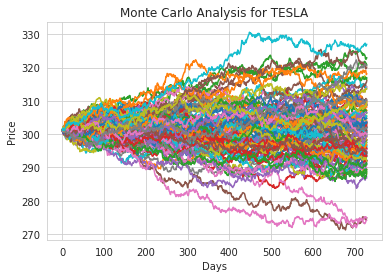

In [ ]:
from past.builtins import xrange
# Get start price from TESLA.tail()
start_price = 301.15

for run in xrange(100):
    figszie=(12,8)
    plt.plot(stock_monte_carlo(start_price,days,mu,sigma) )
plt.xlabel("Days")
plt.ylabel("Price")  
plt.title('Monte Carlo Analysis for TESLA')

In [ ]:
# Set a large numebr of runs
runs = 10000

# Create an empty matrix to hold the end price data
simulations = np.zeros(runs)

# Set the print options of numpy to only display 0-5 points from an array to suppress output
np.set_printoptions(threshold=5)

for run in xrange(runs):    
    # Set the simulation data point as the last stock price for that run
    simulations[run] = stock_monte_carlo(start_price,days,mu,sigma)[days-1];


Sekarang setelah kita memiliki serangkaian simulasi, kita dapat melanjutkan dan memplot histogram, serta menggunakan qunatile untuk menentukan risiko saham ini.

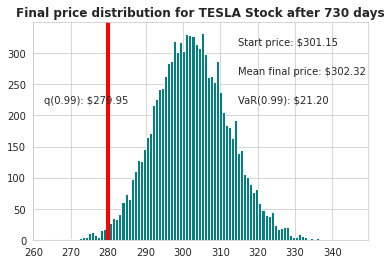

In [ ]:
# Now we'lll define q as the 1% empirical qunatile, this basically means that 99% of the values should fall between here
q = np.percentile(simulations, 1)
    
# Now let's plot the distribution of the end prices
plt.hist(simulations,bins=100, color= "teal")

# Using plt.figtext to fill in some additional information onto the plot

# Starting Price
plt.figtext(0.6, 0.8, s="Start price: $%.2f" %start_price)
# Mean ending price
plt.figtext(0.6, 0.7, "Mean final price: $%.2f" % simulations.mean())

# Variance of the price (within 99% confidence interval)
plt.figtext(0.6, 0.6, "VaR(0.99): $%.2f" % (start_price - q,))

# Display 1% quantile
plt.figtext(0.15, 0.6, "q(0.99): $%.2f" % q)

# Plot a line at the 1% quantile result
plt.axvline(x=q, linewidth=4, color='r')

# Title
plt.title(u"Final price distribution for TESLA Stock after %s days" % days, weight='bold');

Sekarang kita telah melihat kuantil empiris 1% dari distribusi harga akhir untuk memperkirakan Nilai yang Berisiko untuk saham TESLA, yang terlihat menjadi $ 21,20 untuk setiap investasi sebesar 301,15 (harga satu saham TESLA awal).

Ini pada dasarnya berarti untuk setiap saham awal yang Anda beli menempatkan sekitar $ 21,20 dengan risiko 99% dari waktu dari Simulasi Monte Carlo kami.